In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load the dataset
data = pd.read_csv('QidianBooks.csv')

# Convert 'latest_update_time' to datetime and calculate days since the earliest date
data['latest_update_time'] = pd.to_datetime(data['latest_update_time'], errors='coerce')
earliest_date = data[data['latest_update_time'] > pd.Timestamp('0001-01-01')]['latest_update_time'].min()
data['days_since_earliest'] = (data['latest_update_time'] - earliest_date).dt.days.fillna(0)

# Fill missing values in 'word_count', 'total_recommend', 'weekly_recommend' with median of their columns
for column in ['word_count', 'total_recommend', 'weekly_recommend']:
    median_value = data[column].median()
    data[column] = data[column].fillna(median_value)

# Handling 'remaining_attributes'
data['remaining_attributes'] = data['remaining_attributes'].apply(lambda x: "['无']" if pd.isnull(x) or x == "none" else x)

# Fill missing or 'none' values in specified columns with 0
for column in ['status', 'contract_vip', 'author_level', 'total_works', 'total_creation_words', 'creation_days']:
    data[column] = data[column].fillna(0)
    data[column] = data[column].replace('none', 0)

# Drop all columns not mentioned in the preprocessing steps
columns_to_keep = ['total_recommend', 'days_since_earliest', 'word_count', 'weekly_recommend',
                   'remaining_attributes', 'status', 'contract_vip', 'author_level', 'total_works',
                   'total_creation_words', 'creation_days']
data = data[columns_to_keep]

# Write the processed data to a new CSV file
processed_file_path = 'Processed_QidianBooks.csv'
data.to_csv(processed_file_path, index=False)

processed_file_path


'Processed_QidianBooks.csv'

In [2]:
# Load the processed data from the previously created CSV file
processed_data = pd.read_csv('Processed_QidianBooks.csv')

# Convert 'remaining_attributes' from string representation of list to actual list
import ast
processed_data['remaining_attributes'] = processed_data['remaining_attributes'].apply(ast.literal_eval)

# One-hot encode the 'remaining_attributes' column
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
remaining_attributes_encoded = mlb.fit_transform(processed_data['remaining_attributes'])
remaining_attributes_df = pd.DataFrame(remaining_attributes_encoded, columns=mlb.classes_)

# Concatenate the original dataframe with the new one-hot encoded dataframe
final_data = pd.concat([processed_data.drop('remaining_attributes', axis=1), remaining_attributes_df], axis=1)

final_data.head()


,total_recommend,days_since_earliest,word_count,weekly_recommend,status,contract_vip,author_level,total_works,total_creation_words,creation_days,...,进化变异,都市,都市异能,都市生活,青年故事,青春校园,青春疼痛,青春纯爱,高武世界,魔法幻情
0,0,65.0,262800,0,1,1,2,4,2250000,506,...,0,1,1,0,0,0,0,0,0,0
1,3,38.0,110800,0,0,1,3,2,910000,199,...,0,1,0,0,0,0,0,0,0,0
2,704,145.0,268000,4,0,1,2,2,1190000,223,...,0,0,0,0,0,0,0,0,0,0
3,24,43.0,117400,0,0,0,0,1,120000,68,...,0,1,0,0,0,0,0,0,0,0
4,15,16.0,36300,0,0,0,0,3,79000,27,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Save the final data to a new CSV file
final_csv_path = 'Final_Processed_QidianBooks.csv'
final_data.to_csv(final_csv_path, index=False)
final_csv_path


'Final_Processed_QidianBooks.csv'

In [35]:
# Load the final processed data
final_data_path = 'Final_Processed_QidianBooks.csv'
final_processed_data = pd.read_csv(final_data_path)

# Display the first few rows to confirm the structure and to proceed with building the linear regression model
final_processed_data.head()


,total_recommend,days_since_earliest,word_count,weekly_recommend,status,contract_vip,author_level,total_works,total_creation_words,creation_days,...,进化变异,都市,都市异能,都市生活,青年故事,青春校园,青春疼痛,青春纯爱,高武世界,魔法幻情
0,0,65.0,262800,0,1,1,2,4,2250000,506,...,0,1,1,0,0,0,0,0,0,0
1,3,38.0,110800,0,0,1,3,2,910000,199,...,0,1,0,0,0,0,0,0,0,0
2,704,145.0,268000,4,0,1,2,2,1190000,223,...,0,0,0,0,0,0,0,0,0,0
3,24,43.0,117400,0,0,0,0,1,120000,68,...,0,1,0,0,0,0,0,0,0,0
4,15,16.0,36300,0,0,0,0,3,79000,27,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Setting up features and target variable
X = final_processed_data.drop('total_recommend', axis=1)
y = final_processed_data['total_recommend']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = linear_regression_model.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mse


4076861.809212775

In [6]:
# Calculating the R^2 score for the model
r_squared = linear_regression_model.score(X_test, y_test)
r_squared


0.18950519871073357

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Creating and training the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
rf_y_pred = random_forest_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r_squared = random_forest_model.score(X_test, y_test)

# Creating and training the Neural Network model
mlp_model = MLPRegressor(random_state=42, max_iter=500)
mlp_model.fit(X_train, y_train)
mlp_y_pred = mlp_model.predict(X_test)
mlp_mse = mean_squared_error(y_test, mlp_y_pred)
mlp_r_squared = mlp_model.score(X_test, y_test)

(rf_mse, rf_r_squared, mlp_mse, mlp_r_squared)


(3814213.58356, 0.24172061130538547, 5830552.086409327, -0.15913474035401376)

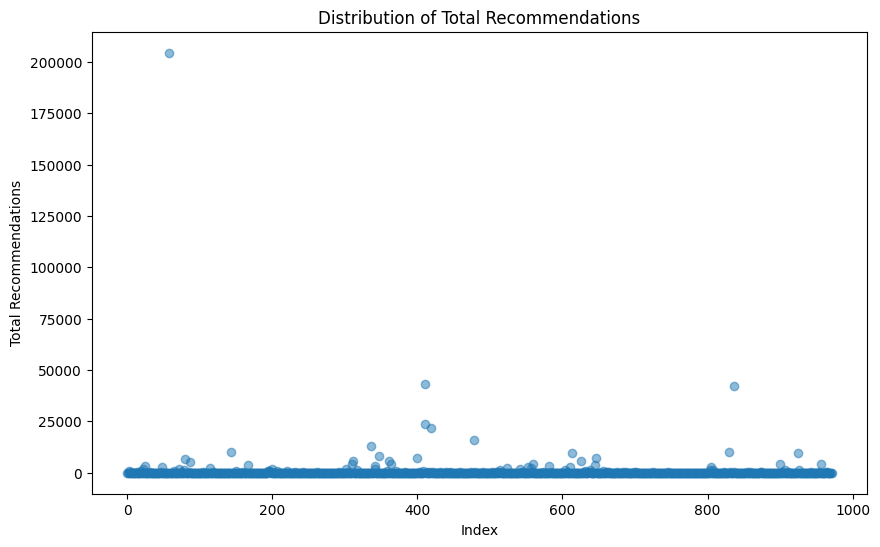

In [8]:
import matplotlib.pyplot as plt

# Plotting the distribution of 'total_recommend'
plt.figure(figsize=(10, 6))
plt.scatter(range(len(final_processed_data['total_recommend'])), final_processed_data['total_recommend'], alpha=0.5)
plt.title('Distribution of Total Recommendations')
plt.xlabel('Index')
plt.ylabel('Total Recommendations')
plt.show()


In [9]:

# Calculating the number of books with total_recommend not equal to zero
total_non_zero = (final_processed_data['total_recommend'] > 10).sum()
total_books = len(final_processed_data)
percentage_non_zero = (total_non_zero / total_books) * 100

(total_non_zero, percentage_non_zero)


(488, 50.20576131687243)

In [13]:
# Filtering out books with total_recommend less than 10
filtered_data = final_processed_data[(final_processed_data['total_recommend'] >= 10) & (final_processed_data['total_recommend'] <= 100000)]


# Selecting specific columns for input features
selected_columns = ['author_level', 'total_works', 'total_creation_words', 'creation_days', 'word_count', 'weekly_recommend']

#selected_columns = [total_recommend,days_since_earliest,word_count,weekly_recommend,status,contract_vip,author_level,total_works,total_creation_words,creation_days,东方玄幻,两宋元明,两晋隋唐,人文博览,人物传记,人间百态,仙侠,仙侠奇缘,仙侣奇缘,传统武侠,体育,侦探推理,修真文明,其他衍生,军事,军事战争,军旅生涯,剑与魔法,历史,历史神话,原生幻想,叛逆成长,古代情缘,古代言情,古典仙侠,古典架空,古武未来,古武机甲,另类幻想,史诗奇幻,唯美幻想,商战职场,国术无双,外国历史,奇妙世界,奇幻,女尊王朝,女性题材,娱乐明星,婚恋情缘,宫闱宅斗,家与情感,家庭伦理,幻想修仙,幽情奇缘,异世大陆,异族恋情,异术超能,异能超术,影视剧本,影视衍生,恋爱日常,悬疑,悬疑探险,悬疑推理,战争幻想,抗战烽火,探索科幻,探险生存,搞笑吐槽,无限,时代叙事,时空穿梭,星际文明,未来世界,末世危机,架空历史,武侠,武侠同人,武侠幻想,浪漫青春,游戏,游戏异界,游戏系统,热血江湖,玄幻,玄幻言情,王朝争霸,现代修真,现代言情,现代魔法,现实,现实生活,生活随笔,电子竞技,短故事,短篇,短篇小说,神秘幻想,神话修真,科幻,科幻空间,秦汉三国,穿越奇情,篮球运动,经商种田,综漫,虚拟网游,'行业人生','衍生同人','诗歌散文','诡秘悬疑','诸天','诸天无限','谍战特工','豪门世家','超级科技','足球运动','轻小说','进化变异','都市','都市异能','都市生活','青年故事','青春校园','青春疼痛','青春纯爱','高武世界','魔法幻情']
X_filtered = filtered_data[selected_columns]
#X_filtered = filtered_data.drop('total_recommend', axis=1)
y_filtered = filtered_data['total_recommend']

# Splitting the data into training and testing sets for the filtered dataset
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Creating and training the linear regression model on filtered data
linear_regression_filtered = LinearRegression()
linear_regression_filtered.fit(X_train_filtered, y_train_filtered)
lr_y_pred_filtered = linear_regression_filtered.predict(X_test_filtered)
lr_mse_filtered = mean_squared_error(y_test_filtered, lr_y_pred_filtered)
lr_r_squared_filtered = linear_regression_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Random Forest model on filtered data
random_forest_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_filtered.fit(X_train_filtered, y_train_filtered)
rf_y_pred_filtered = random_forest_filtered.predict(X_test_filtered)
rf_mse_filtered = mean_squared_error(y_test_filtered, rf_y_pred_filtered)
rf_r_squared_filtered = random_forest_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Neural Network model on filtered data
mlp_filtered = MLPRegressor(random_state=42, max_iter=500)
mlp_filtered.fit(X_train_filtered, y_train_filtered)
mlp_y_pred_filtered = mlp_filtered.predict(X_test_filtered)
mlp_mse_filtered = mean_squared_error(y_test_filtered, mlp_y_pred_filtered)
mlp_r_squared_filtered = mlp_filtered.score(X_test_filtered, y_test_filtered)

(lr_mse_filtered, lr_r_squared_filtered, rf_mse_filtered, rf_r_squared_filtered, mlp_mse_filtered, mlp_r_squared_filtered)


(14361824.94159559,
 0.38214803114610296,
 9135391.550567962,
 0.606991473665561,
 27062690.751692336,
 -0.16424875191102273)

In [14]:
# Filtering out books with total_recommend less than 10
filtered_data = final_processed_data[(final_processed_data['total_recommend'] >= 10) & (final_processed_data['total_recommend'] <= 100000)]


# Selecting specific columns for input features
#selected_columns = ['author_level', 'total_works', 'total_creation_words', 'creation_days', 'word_count', 'weekly_recommend']
selected_columns = ['author_level',  'total_creation_words', 'creation_days', 'word_count', 'weekly_recommend']
#selected_columns = [total_recommend,days_since_earliest,word_count,weekly_recommend,status,contract_vip,author_level,total_works,total_creation_words,creation_days,东方玄幻,两宋元明,两晋隋唐,人文博览,人物传记,人间百态,仙侠,仙侠奇缘,仙侣奇缘,传统武侠,体育,侦探推理,修真文明,其他衍生,军事,军事战争,军旅生涯,剑与魔法,历史,历史神话,原生幻想,叛逆成长,古代情缘,古代言情,古典仙侠,古典架空,古武未来,古武机甲,另类幻想,史诗奇幻,唯美幻想,商战职场,国术无双,外国历史,奇妙世界,奇幻,女尊王朝,女性题材,娱乐明星,婚恋情缘,宫闱宅斗,家与情感,家庭伦理,幻想修仙,幽情奇缘,异世大陆,异族恋情,异术超能,异能超术,影视剧本,影视衍生,恋爱日常,悬疑,悬疑探险,悬疑推理,战争幻想,抗战烽火,探索科幻,探险生存,搞笑吐槽,无限,时代叙事,时空穿梭,星际文明,未来世界,末世危机,架空历史,武侠,武侠同人,武侠幻想,浪漫青春,游戏,游戏异界,游戏系统,热血江湖,玄幻,玄幻言情,王朝争霸,现代修真,现代言情,现代魔法,现实,现实生活,生活随笔,电子竞技,短故事,短篇,短篇小说,神秘幻想,神话修真,科幻,科幻空间,秦汉三国,穿越奇情,篮球运动,经商种田,综漫,虚拟网游,'行业人生','衍生同人','诗歌散文','诡秘悬疑','诸天','诸天无限','谍战特工','豪门世家','超级科技','足球运动','轻小说','进化变异','都市','都市异能','都市生活','青年故事','青春校园','青春疼痛','青春纯爱','高武世界','魔法幻情']
X_filtered = filtered_data[selected_columns]
#X_filtered = filtered_data.drop('total_recommend', axis=1)
y_filtered = filtered_data['total_recommend']

# Splitting the data into training and testing sets for the filtered dataset
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Creating and training the linear regression model on filtered data
linear_regression_filtered = LinearRegression()
linear_regression_filtered.fit(X_train_filtered, y_train_filtered)
lr_y_pred_filtered = linear_regression_filtered.predict(X_test_filtered)
lr_mse_filtered = mean_squared_error(y_test_filtered, lr_y_pred_filtered)
lr_r_squared_filtered = linear_regression_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Random Forest model on filtered data
random_forest_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_filtered.fit(X_train_filtered, y_train_filtered)
rf_y_pred_filtered = random_forest_filtered.predict(X_test_filtered)
rf_mse_filtered = mean_squared_error(y_test_filtered, rf_y_pred_filtered)
rf_r_squared_filtered = random_forest_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Neural Network model on filtered data
mlp_filtered = MLPRegressor(random_state=42, max_iter=500)
mlp_filtered.fit(X_train_filtered, y_train_filtered)
mlp_y_pred_filtered = mlp_filtered.predict(X_test_filtered)
mlp_mse_filtered = mean_squared_error(y_test_filtered, mlp_y_pred_filtered)
mlp_r_squared_filtered = mlp_filtered.score(X_test_filtered, y_test_filtered)

(lr_mse_filtered, lr_r_squared_filtered, rf_mse_filtered, rf_r_squared_filtered, mlp_mse_filtered, mlp_r_squared_filtered)


(14420316.177076198,
 0.37963171270124263,
 9742377.59872524,
 0.5808786693077637,
 18147348.972875725,
 0.21929313732991884)

In [17]:
# Filtering out books with total_recommend less than 10
filtered_data = final_processed_data[(final_processed_data['total_recommend'] >= 10) & (final_processed_data['total_recommend'] <= 100000)]


# Selecting specific columns for input features
#selected_columns = ['author_level', 'total_works', 'total_creation_words', 'creation_days', 'word_count', 'weekly_recommend']
selected_columns = ['author_level',  'total_creation_words', 'word_count', 'weekly_recommend']
#selected_columns = [total_recommend,days_since_earliest,word_count,weekly_recommend,status,contract_vip,author_level,total_works,total_creation_words,creation_days,东方玄幻,两宋元明,两晋隋唐,人文博览,人物传记,人间百态,仙侠,仙侠奇缘,仙侣奇缘,传统武侠,体育,侦探推理,修真文明,其他衍生,军事,军事战争,军旅生涯,剑与魔法,历史,历史神话,原生幻想,叛逆成长,古代情缘,古代言情,古典仙侠,古典架空,古武未来,古武机甲,另类幻想,史诗奇幻,唯美幻想,商战职场,国术无双,外国历史,奇妙世界,奇幻,女尊王朝,女性题材,娱乐明星,婚恋情缘,宫闱宅斗,家与情感,家庭伦理,幻想修仙,幽情奇缘,异世大陆,异族恋情,异术超能,异能超术,影视剧本,影视衍生,恋爱日常,悬疑,悬疑探险,悬疑推理,战争幻想,抗战烽火,探索科幻,探险生存,搞笑吐槽,无限,时代叙事,时空穿梭,星际文明,未来世界,末世危机,架空历史,武侠,武侠同人,武侠幻想,浪漫青春,游戏,游戏异界,游戏系统,热血江湖,玄幻,玄幻言情,王朝争霸,现代修真,现代言情,现代魔法,现实,现实生活,生活随笔,电子竞技,短故事,短篇,短篇小说,神秘幻想,神话修真,科幻,科幻空间,秦汉三国,穿越奇情,篮球运动,经商种田,综漫,虚拟网游,'行业人生','衍生同人','诗歌散文','诡秘悬疑','诸天','诸天无限','谍战特工','豪门世家','超级科技','足球运动','轻小说','进化变异','都市','都市异能','都市生活','青年故事','青春校园','青春疼痛','青春纯爱','高武世界','魔法幻情']
X_filtered = filtered_data[selected_columns]
#X_filtered = filtered_data.drop('total_recommend', axis=1)
y_filtered = filtered_data['total_recommend']

# Splitting the data into training and testing sets for the filtered dataset
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Creating and training the linear regression model on filtered data
linear_regression_filtered = LinearRegression()
linear_regression_filtered.fit(X_train_filtered, y_train_filtered)
lr_y_pred_filtered = linear_regression_filtered.predict(X_test_filtered)
lr_mse_filtered = mean_squared_error(y_test_filtered, lr_y_pred_filtered)
lr_r_squared_filtered = linear_regression_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Random Forest model on filtered data
random_forest_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_filtered.fit(X_train_filtered, y_train_filtered)
rf_y_pred_filtered = random_forest_filtered.predict(X_test_filtered)
rf_mse_filtered = mean_squared_error(y_test_filtered, rf_y_pred_filtered)
rf_r_squared_filtered = random_forest_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Neural Network model on filtered data
mlp_filtered = MLPRegressor(random_state=42, max_iter=500)
mlp_filtered.fit(X_train_filtered, y_train_filtered)
mlp_y_pred_filtered = mlp_filtered.predict(X_test_filtered)
mlp_mse_filtered = mean_squared_error(y_test_filtered, mlp_y_pred_filtered)
mlp_r_squared_filtered = mlp_filtered.score(X_test_filtered, y_test_filtered)

(lr_mse_filtered, lr_r_squared_filtered, rf_mse_filtered, rf_r_squared_filtered, mlp_mse_filtered, mlp_r_squared_filtered)


(14299079.016165286,
 0.3848473882070842,
 8849085.498868804,
 0.6193084848014354,
 19676616.746040154,
 0.15350337116880286)

In [16]:
# Filtering out books with total_recommend less than 10
filtered_data = final_processed_data[(final_processed_data['total_recommend'] >= 10) & (final_processed_data['total_recommend'] <= 100000)]


# Selecting specific columns for input features
#selected_columns = ['author_level', 'total_works', 'total_creation_words', 'creation_days', 'word_count', 'weekly_recommend']
selected_columns = ['author_level',  'word_count', 'weekly_recommend']
#selected_columns = [total_recommend,days_since_earliest,word_count,weekly_recommend,status,contract_vip,author_level,total_works,total_creation_words,creation_days,东方玄幻,两宋元明,两晋隋唐,人文博览,人物传记,人间百态,仙侠,仙侠奇缘,仙侣奇缘,传统武侠,体育,侦探推理,修真文明,其他衍生,军事,军事战争,军旅生涯,剑与魔法,历史,历史神话,原生幻想,叛逆成长,古代情缘,古代言情,古典仙侠,古典架空,古武未来,古武机甲,另类幻想,史诗奇幻,唯美幻想,商战职场,国术无双,外国历史,奇妙世界,奇幻,女尊王朝,女性题材,娱乐明星,婚恋情缘,宫闱宅斗,家与情感,家庭伦理,幻想修仙,幽情奇缘,异世大陆,异族恋情,异术超能,异能超术,影视剧本,影视衍生,恋爱日常,悬疑,悬疑探险,悬疑推理,战争幻想,抗战烽火,探索科幻,探险生存,搞笑吐槽,无限,时代叙事,时空穿梭,星际文明,未来世界,末世危机,架空历史,武侠,武侠同人,武侠幻想,浪漫青春,游戏,游戏异界,游戏系统,热血江湖,玄幻,玄幻言情,王朝争霸,现代修真,现代言情,现代魔法,现实,现实生活,生活随笔,电子竞技,短故事,短篇,短篇小说,神秘幻想,神话修真,科幻,科幻空间,秦汉三国,穿越奇情,篮球运动,经商种田,综漫,虚拟网游,'行业人生','衍生同人','诗歌散文','诡秘悬疑','诸天','诸天无限','谍战特工','豪门世家','超级科技','足球运动','轻小说','进化变异','都市','都市异能','都市生活','青年故事','青春校园','青春疼痛','青春纯爱','高武世界','魔法幻情']
X_filtered = filtered_data[selected_columns]
#X_filtered = filtered_data.drop('total_recommend', axis=1)
y_filtered = filtered_data['total_recommend']

# Splitting the data into training and testing sets for the filtered dataset
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Creating and training the linear regression model on filtered data
linear_regression_filtered = LinearRegression()
linear_regression_filtered.fit(X_train_filtered, y_train_filtered)
lr_y_pred_filtered = linear_regression_filtered.predict(X_test_filtered)
lr_mse_filtered = mean_squared_error(y_test_filtered, lr_y_pred_filtered)
lr_r_squared_filtered = linear_regression_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Random Forest model on filtered data
random_forest_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_filtered.fit(X_train_filtered, y_train_filtered)
rf_y_pred_filtered = random_forest_filtered.predict(X_test_filtered)
rf_mse_filtered = mean_squared_error(y_test_filtered, rf_y_pred_filtered)
rf_r_squared_filtered = random_forest_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Neural Network model on filtered data
mlp_filtered = MLPRegressor(random_state=42, max_iter=500)
mlp_filtered.fit(X_train_filtered, y_train_filtered)
mlp_y_pred_filtered = mlp_filtered.predict(X_test_filtered)
mlp_mse_filtered = mean_squared_error(y_test_filtered, mlp_y_pred_filtered)
mlp_r_squared_filtered = mlp_filtered.score(X_test_filtered, y_test_filtered)

(lr_mse_filtered, lr_r_squared_filtered, rf_mse_filtered, rf_r_squared_filtered, mlp_mse_filtered, mlp_r_squared_filtered)


(14740959.82882609,
 0.36583748304450914,
 8766327.477125142,
 0.6228687709684589,
 19986288.615782715,
 0.14018115235627826)

In [36]:
# Filtering out books with total_recommend less than 10
filtered_data = final_processed_data[(final_processed_data['total_recommend'] >= 20) & (final_processed_data['total_recommend'] <= 100000)]


# Selecting specific columns for input features
#selected_columns = ['author_level', 'total_works', 'total_creation_words', 'creation_days', 'word_count', 'weekly_recommend']
selected_columns = [ 'author_level','total_creation_words','word_count', 'weekly_recommend']
#selected_columns = [total_recommend,days_since_earliest,word_count,weekly_recommend,status,contract_vip,author_level,total_works,total_creation_words,creation_days,东方玄幻,两宋元明,两晋隋唐,人文博览,人物传记,人间百态,仙侠,仙侠奇缘,仙侣奇缘,传统武侠,体育,侦探推理,修真文明,其他衍生,军事,军事战争,军旅生涯,剑与魔法,历史,历史神话,原生幻想,叛逆成长,古代情缘,古代言情,古典仙侠,古典架空,古武未来,古武机甲,另类幻想,史诗奇幻,唯美幻想,商战职场,国术无双,外国历史,奇妙世界,奇幻,女尊王朝,女性题材,娱乐明星,婚恋情缘,宫闱宅斗,家与情感,家庭伦理,幻想修仙,幽情奇缘,异世大陆,异族恋情,异术超能,异能超术,影视剧本,影视衍生,恋爱日常,悬疑,悬疑探险,悬疑推理,战争幻想,抗战烽火,探索科幻,探险生存,搞笑吐槽,无限,时代叙事,时空穿梭,星际文明,未来世界,末世危机,架空历史,武侠,武侠同人,武侠幻想,浪漫青春,游戏,游戏异界,游戏系统,热血江湖,玄幻,玄幻言情,王朝争霸,现代修真,现代言情,现代魔法,现实,现实生活,生活随笔,电子竞技,短故事,短篇,短篇小说,神秘幻想,神话修真,科幻,科幻空间,秦汉三国,穿越奇情,篮球运动,经商种田,综漫,虚拟网游,'行业人生','衍生同人','诗歌散文','诡秘悬疑','诸天','诸天无限','谍战特工','豪门世家','超级科技','足球运动','轻小说','进化变异','都市','都市异能','都市生活','青年故事','青春校园','青春疼痛','青春纯爱','高武世界','魔法幻情']
X_filtered = filtered_data[selected_columns]
#X_filtered = filtered_data.drop('total_recommend', axis=1)
y_filtered = filtered_data['total_recommend']

# Splitting the data into training and testing sets for the filtered dataset
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Creating and training the linear regression model on filtered data
linear_regression_filtered = LinearRegression()
linear_regression_filtered.fit(X_train_filtered, y_train_filtered)
lr_y_pred_filtered = linear_regression_filtered.predict(X_test_filtered)
lr_mse_filtered = mean_squared_error(y_test_filtered, lr_y_pred_filtered)
lr_r_squared_filtered = linear_regression_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Random Forest model on filtered data
random_forest_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_filtered.fit(X_train_filtered, y_train_filtered)
rf_y_pred_filtered = random_forest_filtered.predict(X_test_filtered)
rf_mse_filtered = mean_squared_error(y_test_filtered, rf_y_pred_filtered)
rf_r_squared_filtered = random_forest_filtered.score(X_test_filtered, y_test_filtered)

# Creating and training the Neural Network model on filtered data
mlp_filtered = MLPRegressor(random_state=42, max_iter=500)
mlp_filtered.fit(X_train_filtered, y_train_filtered)
mlp_y_pred_filtered = mlp_filtered.predict(X_test_filtered)
mlp_mse_filtered = mean_squared_error(y_test_filtered, mlp_y_pred_filtered)
mlp_r_squared_filtered = mlp_filtered.score(X_test_filtered, y_test_filtered)

(lr_mse_filtered, lr_r_squared_filtered, rf_mse_filtered, rf_r_squared_filtered, mlp_mse_filtered, mlp_r_squared_filtered)


(1724193.149905055,
 0.6704822054331798,
 1614953.1689196548,
 0.6913595170121132,
 110767079.26798643,
 -20.169161745599645)

In [39]:
# Displaying a few rows of actual vs predicted values for the total_recommend using the linear regression model
# Since the linear regression model was last trained on the entire dataset, we will use that for demonstration.
# Let's use the filtered dataset for this purpose.

# Predicting on the filtered test set
filtered_lr_y_pred = random_forest_filtered.predict(X_test_filtered)

# Creating a DataFrame to display actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test_filtered,
    'Predicted': filtered_lr_y_pred
}).reset_index(drop=True)

# Assuming 'filtered_lr_y_pred' contains predictions from a previously trained Linear Regression model on filtered data

# Creating a DataFrame to display actual and predicted values using Random Forest predictions instead
comparison_df_rf = pd.DataFrame({
    'Actual': y_test_filtered,
    'Predicted': filtered_lr_y_pred
}).reset_index(drop=True)

# Writing the DataFrame to a CSV file
comparison_csv_path = 'Filtered_RandomForest_Predictions.csv'
comparison_df_rf.to_csv(comparison_csv_path, index=False)

comparison_csv_path



'Filtered_RandomForest_Predictions.csv'

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# 加载数据
data_path = 'Final_Processed_QidianBooks.csv'  # 请替换为您的文件路径
data = pd.read_csv(data_path)

# 筛选符合条件的数据
filtered_data = data[(data['total_recommend'] > 10) & (data['total_recommend'] <= 100000)]

# 分割数据
X = filtered_data.drop('total_recommend', axis=1)
y = filtered_data['total_recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练线性回归模型
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
lr_predictions = linear_model.predict(X_test)
lr_predictions = np.maximum(lr_predictions, 10)  # 确保预测值不小于10
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r_squared = linear_model.score(X_test, y_test)

# 训练随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_predictions = np.maximum(rf_predictions, 10)  # 确保预测值不小于10
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r_squared = rf_model.score(X_test, y_test)

# 训练神经网络模型
mlp_model = MLPRegressor(random_state=42, max_iter=500)
mlp_model.fit(X_train, y_train)
mlp_predictions = mlp_model.predict(X_test)
mlp_predictions = np.maximum(mlp_predictions, 10)  # 确保预测值不小于10
mlp_mse = mean_squared_error(y_test, mlp_predictions)
mlp_r_squared = mlp_model.score(X_test, y_test)

# 打印结果
print("Linear Regression MSE:", lr_mse)
print("Linear Regression R^2:", lr_r_squared)
print("Random Forest MSE:", rf_mse)
print("Random Forest R^2:", rf_r_squared)
print("MLP Regressor MSE:", mlp_mse)
print("MLP Regressor R^2:", mlp_r_squared)


Linear Regression MSE: 6551096.4851292465
Linear Regression R^2: 0.22892632172519556
Random Forest MSE: 7189280.310357142
Random Forest R^2: 0.21228895746432153
MLP Regressor MSE: 8472046.955444247
MLP Regressor R^2: 0.06333594717095536
